In [25]:
import pyxdf
import numpy as np
streams, header = pyxdf.load_xdf('sub-P503\ses-S001\eeg\sub-P503_ses-S001_task-Default_run-001_eeg.xdf')

stream_2 = streams[1]
stream_3 = streams[2]
def is_marker_stream(stream):
    time_series = stream['time_series'].flatten()
    unique_values = np.unique(time_series)
    if np.array_equal(unique_values, [0, 1]):
        Marker_stream = stream
        return True
    return False
# Debugging
print(f' stream 0 marker {(is_marker_stream(streams[0]))}')
print(f' stream 1 marker {(is_marker_stream(streams[1]))}')
print(f' stream 2 marker {(is_marker_stream(streams[2]))}')
print(' ')

def is_Rawtime_stream(stream):
    data = np.abs(stream['time_series'].flatten()) 
    mean_value = np.mean(data) 
    if mean_value > 100:
        return True
        # return f'{True}     mean value = {mean_value}'
    else:
        return False
        # return f'{False}    mean value = {mean_value}'

# Debugging
print(f' stream 0 marker {(is_Rawtime_stream(streams[0]))}')
print(f' stream 1 marker {(is_Rawtime_stream(streams[1]))}')
print(f' stream 2 marker {(is_Rawtime_stream(streams[2]))}')

EMG_stream  = None
Maker_stream  = None
Rawtime_stream  = None

for stream in streams:
    if is_Rawtime_stream(stream):
        Rawtime_stream = stream
    elif is_marker_stream(stream):
        Marker_stream = stream
    else:
        EMG_stream = stream

print(f'EMG_stream Info:"       {EMG_stream['info']['name']}')
print(f'Marker_stream Info:"    {Marker_stream['info']['name']}')
print(f'Rawtime_stream Info:"   {Rawtime_stream['info']['name']}')

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_19436\2755501480.py:3: SyntaxWarning: invalid escape sequence '\s'
  streams, header = pyxdf.load_xdf('sub-P503\ses-S001\eeg\sub-P503_ses-S001_task-Default_run-001_eeg.xdf')
Stream 2: Calculated effective sampling rate 53.1738 Hz is different from specified rate 250.0000 Hz.


 stream 0 marker False
 stream 1 marker True
 stream 2 marker False
 
 stream 0 marker False
 stream 1 marker False
 stream 2 marker True
EMG_stream Info:"       ['obci_EMG']
Marker_stream Info:"    ['obci_Marker']
Rawtime_stream Info:"   ['obci_Timeraw']


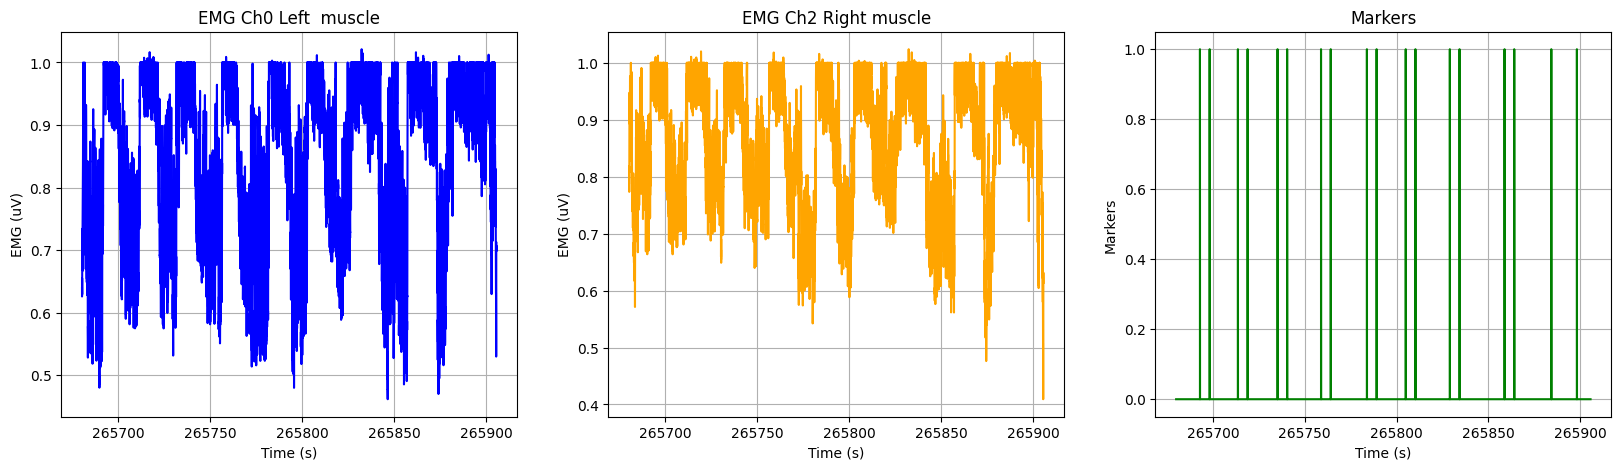

In [26]:
import matplotlib.pyplot as plt


EMG_timeseries_Ch0 = EMG_stream['time_series'][:,0]
EMG_timeseries_Ch2 = EMG_stream['time_series'][:,2]
EMG_timestamps = EMG_stream['time_stamps']

Maker_timeseries = Marker_stream['time_series']
Maker_timestamps = Marker_stream['time_stamps']

fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
ax[0].plot(EMG_timestamps, EMG_timeseries_Ch0, label='EMG Ch0 Left  muscle', color='b')
ax[0].set_title('EMG Ch0 Left  muscle')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('EMG (uV)')
ax[0].grid()

ax[1].plot(EMG_timestamps, EMG_timeseries_Ch2, label='EMG Ch2 Right muscle', color='orange')
ax[1].set_title('EMG Ch2 Right muscle')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('EMG (uV)')
ax[1].grid()

ax[2].plot(Maker_timestamps, Maker_timeseries, label='Markers', color='g')
ax[2].set_title('Markers')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Markers')
ax[2].grid()

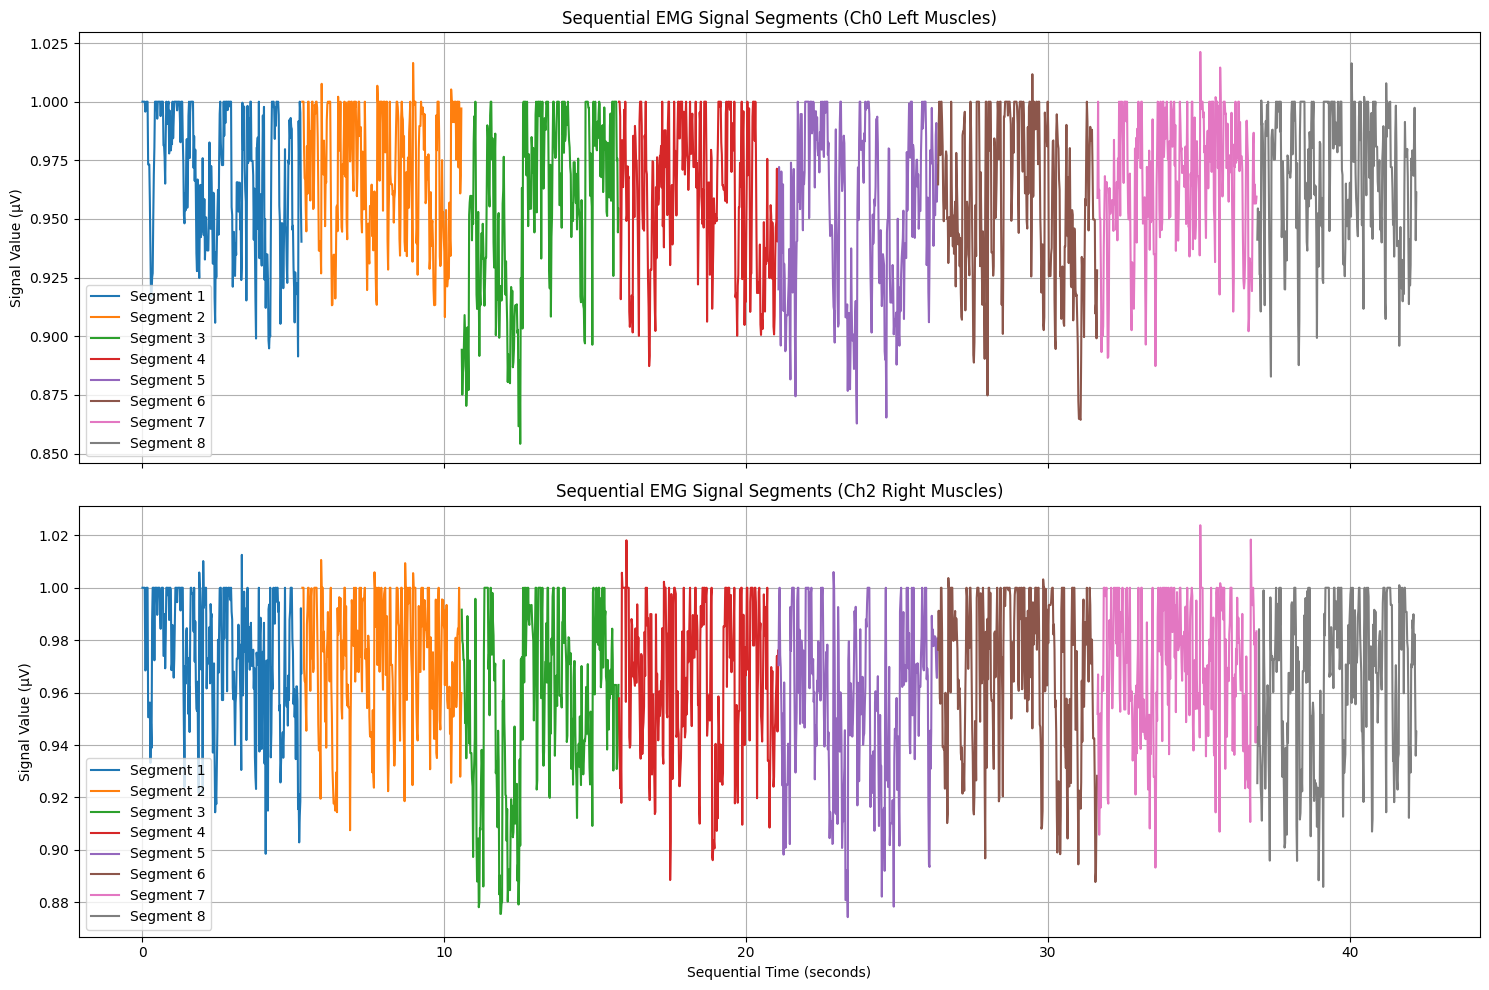

Ch0 Smoothness: 0.016259334981441498
Ch0 Variance: 0.0010099102510139346
Ch2 Smoothness: 0.016715407371520996
Ch2 Variance: 0.0008429971639998257


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# สมมติว่า EMG และ Marker stream ถูกตั้งค่ามาแล้ว
time_stamps_EMG = EMG_timestamps
time_series_EMG_ch0 = EMG_timeseries_Ch0
time_series_EMG_ch2 = EMG_timeseries_Ch2

time_stamps_Marker = Maker_timestamps
time_series_Marker = Maker_timeseries

# ค้นหา marker ที่มีค่า 1
marker_on_indices = np.where(np.isclose(time_series_Marker, 1, atol=1e-6))[0]
marker_on_timestamps = time_stamps_Marker[marker_on_indices]

# เก็บข้อมูลช่วง marker ที่ valid+
marker_segments = []
time_series_marker_ch0 = []
time_series_marker_ch2 = []
time_stamps_marker = []

# plt.figure()
for i, idx in enumerate(marker_on_indices[:-1]):
    current_time = time_stamps_Marker[idx]
    next_time = time_stamps_Marker[marker_on_indices[i + 1]]

    # ตรวจสอบว่า segment อยู่ในช่วงที่กำหนด
    if 4.8 < next_time - current_time <= 6:
        marker_segments.append((current_time, next_time))

        # ดึงข้อมูลในช่วงที่สนใจ
        segment_indices = np.where((time_stamps_EMG >= current_time) & (time_stamps_EMG <= next_time))
        time_series_marker_ch0.append(time_series_EMG_ch0[segment_indices])
        time_series_marker_ch2.append(time_series_EMG_ch2[segment_indices])
        time_stamps_marker.append(time_stamps_EMG[segment_indices])

# สร้าง plot แบบสองแถว
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)  # สร้าง subplot 2 แถว 1 คอลัมน์
offset = 0

# Plot สำหรับ Ch0 (แถวแรก)
for i, (start, end) in enumerate(marker_segments):
    segment_time = time_stamps_marker[i]
    segment_signal_ch0 = time_series_marker_ch0[i]
    adjusted_time = segment_time - start + offset
    axs[0].plot(adjusted_time, segment_signal_ch0, label=f"Segment {i + 1}")
    offset += end - start

axs[0].set_title("Sequential EMG Signal Segments (Ch0 Left Muscles)")
axs[0].set_ylabel("Signal Value (μV)")
axs[0].grid()
axs[0].legend()

# Reset offset สำหรับ Ch2 (แถวที่สอง)
offset = 0

# Plot สำหรับ Ch2 (แถวที่สอง)
for i, (start, end) in enumerate(marker_segments):
    segment_time = time_stamps_marker[i]
    segment_signal_ch2 = time_series_marker_ch2[i]
    adjusted_time = segment_time - start + offset
    axs[1].plot(adjusted_time, segment_signal_ch2, label=f"Segment {i + 1}")
    offset += end - start

axs[1].set_title("Sequential EMG Signal Segments (Ch2 Right Muscles)")
axs[1].set_xlabel("Sequential Time (seconds)")
axs[1].set_ylabel("Signal Value (μV)")
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.savefig('output_graph.png') 
plt.show()

# การคำนวณ Smoothness และ Variance
if time_series_marker_ch0:
    marker_signal_ch0 = np.concatenate(time_series_marker_ch0)
    cal_Smoothness_signal_ch0 = np.mean(np.abs(np.diff(marker_signal_ch0)))
    cal_variance_signal_ch0 = np.var(marker_signal_ch0)
    print(f"Ch0 Smoothness: {cal_Smoothness_signal_ch0}")
    print(f"Ch0 Variance: {cal_variance_signal_ch0}")

if time_series_marker_ch2:
    marker_signal_ch2 = np.concatenate(time_series_marker_ch2)
    cal_Smoothness_signal_ch2 = np.mean(np.abs(np.diff(marker_signal_ch2)))
    cal_variance_signal_ch2 = np.var(marker_signal_ch2)
    print(f"Ch2 Smoothness: {cal_Smoothness_signal_ch2}")
    print(f"Ch2 Variance: {cal_variance_signal_ch2}")
